In [2]:
import wikipediaapi
from ultralytics import YOLO
import os
import requests
import folium
from wikipediaapi import Wikipedia
import google.generativeai as genai
import matplotlib.pyplot as plt
from datetime import datetime
from io import BytesIO
import time
import pandas as pd

In [9]:
# import langchain.chains
# import langchain.llms
# print(dir(langchain.chains))
# print(" ")
# print(dir(langchain.chains.llm))
# print(" ")
# print(dir(langchain.llms))

In [10]:
# Load YOLOv11 model with the pre-trained weights
def load_yolov11_model(weights_path='../wildlife.pt'):
    """Loads the YOLOv11 model with the specified weights using the ultralytics library."""
    model = YOLO(weights_path)  # Load the model directly using ultralytics
    return model

yolo_model = load_yolov11_model()

def predict_species(image_path, model):
    results = model(image_path)

    if isinstance(results, list) and len(results) > 0:
        result = results[0]
    else:
        print("No results found.")
        return None

    # Access the probabilities and names
    probs = result.probs
    names = result.names
    species_index = probs.top1
    species_name = names[species_index]

    #print(f"The species is: {species_name}")
    return species_name

In [11]:
# EXAMPLE USAGE
# image_path = "../Data/iwildcam-2022/inaturalist_2017/Mammalia/Acinonyx jubatus/1e4b962eb35f408bc3aeda92cbf0775f.jpg"
### MENTION THE TEST IMAGE FILEPATH HERE ### Use ../ before realtive path!
image_path = "../shera.png"
Answer = predict_species(image_path, yolo_model)
print(f"THE SPECIES IS: {Answer}")


image 1/1 /Users/kanishkaman/Desktop/UMC-301-Project/kanishk_UMC301/../shera.png: 224x224 puma concolor 1.00, aepyceros melampus 0.00, equus quagga 0.00, panthera pardus 0.00, panthera tigris 0.00, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
THE SPECIES IS: puma concolor


In [ ]:
# WIKIPEDIA wala function
def get_wikipedia_info(species_name):
    wiki = wikipediaapi.Wikipedia(
        language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI,
        user_agent="SpeciesInfoScript/1.0 (https://yourwebsite.com; your.email@example.com)"
    )
    page = wiki.page(species_name)
    
    if page.exists():
        return page.text  # Fetch the full text of the page
    else:
        return f"The Wikipedia page for '{species_name}' does not exist."
    

# Function to enhance species info using the Gemini API (GenAI)
def enhance_species_info(info, prompt_addition):
    # Define the prompt for Gemini with user's input added
    prompt = f"Here is some information about a species:\n\n{info}\n\n{prompt_addition}"

    # Configure the API for GenAI
    genai.configure(api_key="") ## MENTION API KEY HERE

    # Create the model configuration
    generation_config = {
        "temperature": 1,
        "top_p": 0.95,
        "top_k": 40,
        "max_output_tokens": 8192,
        "response_mime_type": "text/plain",
    }

    model = genai.GenerativeModel(
        model_name="gemini-1.5-flash",
        generation_config=generation_config,
    )

    chat_session = model.start_chat(
        history=[]
    )

    response = chat_session.send_message(prompt)
    return response

In [13]:
# Main function to get species info and enhance it
def main(image_path):
    # Step 1: Predict species from the image
    species_name = predict_species(image_path, yolo_model)
    if species_name is None:
        print("No species detected.")
        return
    
    print(f"Predicted Species: {species_name}")

    # Step 2: Get Wikipedia information about the species
    species_info = get_wikipedia_info(species_name)
    if "does not exist" in species_info:
        print(species_info)
        return

    # Step 3: Enhance the information using the Gemini API
    prompt_addition = "Give very concise information using the data gathered, start with a short description, then tell what is the Biological Name of Species, what is the conservation status of the animal, population distribution in the world, unique facts, habitat, diet, trivia, etc."
    enhanced_info = enhance_species_info(species_info, prompt_addition)

    print("\nEnhanced Information:")
    print(enhanced_info.text)

# USAGE
main(image_path)


image 1/1 /Users/kanishkaman/Desktop/UMC-301-Project/kanishk_UMC301/../shera.png: 224x224 puma concolor 1.00, aepyceros melampus 0.00, equus quagga 0.00, panthera pardus 0.00, panthera tigris 0.00, 5.8ms
Speed: 2.4ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Predicted Species: puma concolor

Enhanced Information:
The cougar, also known as the panther, mountain lion, catamount and puma, is a large cat native to the Americas. It is the most widely distributed wild, terrestrial mammal in the Western Hemisphere, found from Canada to the southern Andes Mountains. This adaptable species inhabits a variety of habitats, favoring dense underbrush and rocky areas for stalking prey. 

**Biological Name:** _Puma concolor_

**Conservation Status:** Least Concern (IUCN Red List)

**Population Distribution:** Found throughout North, Central and South America, with populations declining due to habitat loss and hunting.

**Unique Facts:**

* Holds the Guinness 

In [ ]:
# Function to get taxonKey for a species name
def get_taxon_key(species_name):
    search_url = "https://api.gbif.org/v1/species/match"
    params = {"name": species_name}
    response = requests.get(search_url, params=params)
    response.raise_for_status()
    data = response.json()
    return data.get("usageKey")

# Function to retrieve occurrences for a species
def get_species_occurrences(taxon_key):
    url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "taxonKey": taxon_key,
        "year": "2023,2024",  # Specify the range of years
        "limit": 300,
        "offset": 0
    }
    
    all_data = []
    
    # Paginate through data
    while len(all_data) < 10000:  # Limit to 1000 records
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print("Error with request:", response.status_code)
            break
        
        data = response.json().get("results", [])
        
        # Break if no more data is available
        if not data:
            break
        
        all_data.extend(data)
        print(f"Retrieved {len(all_data)} records so far...")
        
        params["offset"] += params["limit"]
        time.sleep(1)  # Pause to avoid rate limiting

    return all_data

# Function to plot observations by country
def plot_species_observations_by_country(df):
    # Select necessary columns and group data by country
    df = df[['scientificName', 'country', 'decimalLatitude', 'decimalLongitude', 'year']]
    species_country = df.groupby(['scientificName', 'country']).size().unstack(fill_value=0)
    species_country = species_country.T.head(10)  # Limit to top 10 countries for clarity
    
    plt.figure(figsize=(12, 8))
    species_country.plot(kind='bar', stacked=True, colormap='viridis', width=0.8)
    plt.title('Species Observations by Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Observations')
    plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Main code
species_name = predict_species(image_path, yolo_model)  # Use the image path of your choice
print(f"Predicted species: {species_name}")

taxon_key = get_taxon_key(species_name)
if taxon_key:
    species_data = get_species_occurrences(taxon_key)
    df = pd.DataFrame(species_data)
    print(f"Total records retrieved: {len(df)}")
    
    # Save to CSV or explore further
    df.to_csv("gbif_data.csv", index=False)
    print("Data saved to gbif_data.csv")
    
    # Load and plot data
    plot_species_observations_by_country(df)
else:
    print(f"Taxon key not found for {species_name}")

In [15]:
# # Inspect date-related fields for each entry
# for i, entry in enumerate(gbif_data):  # Limiting to the first 5 for clarity
#     print(f"Entry {i} - eventDate: {entry.get('eventDate')}, year: {entry.get('year')}, month: {entry.get('month')}, day: {entry.get('day')}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# Load the data
df = pd.read_csv("gbif_data.csv")

# Select necessary columns
df = df[['scientificName', 'country', 'decimalLatitude', 'decimalLongitude', 'year']]


# Function to plot species sightings on a world map
def plot_species_sightings(data, predicted_species_name):
    # Extract geographic data
    geo_data = {
        "decimalLatitude": [],
        "decimalLongitude": [],
    }
    for record in data["results"]:
        if "decimalLatitude" in record and "decimalLongitude" in record:
            geo_data["decimalLatitude"].append(record["decimalLatitude"])
            geo_data["decimalLongitude"].append(record["decimalLongitude"])

    # Convert data into a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        geo_data, 
        geometry=gpd.points_from_xy(geo_data["decimalLongitude"], geo_data["decimalLatitude"]),
        crs="EPSG:4326"
    )
    
    # Load the downloaded Natural Earth world data from a local file
    world = gpd.read_file("../kanishk_UMC301/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")  # Update with the correct path
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, color="lightgrey")
    gdf.plot(ax=ax, color="red", markersize=5)
    
    ax.set_title(f"Sightings of {predicted_species_name}")
    plt.show()

# Function to retrieve occurrence data for the predicted species name
def get_species_sightings(predicted_species_name):
    query_params = {
        "scientificName": predicted_species_name,  # Use predicted species name directly
        "limit": 300,
        "hasCoordinate": "true"
    }
    url = "https://api.gbif.org/v1/occurrence/search"
    response = requests.get(url, params=query_params)
    response.raise_for_status()  # Check for HTTP errors
    data = response.json()
    return data

# Main code execution
predicted_species_name = 'panthera pardus'
species_data = get_species_sightings(predicted_species_name)
plot_species_sightings(species_data, predicted_species_name)


In [17]:
print(df.shape)
df.head()

(2172, 5)


,scientificName,country,decimalLatitude,decimalLongitude,year
0,"Puma concolor (Linnaeus, 1771)",United States of America,41.631789,-103.773128,2024
1,"Puma concolor couguar (Kerr, 1792)",United States of America,39.870821,-105.457327,2024
2,"Puma concolor (Linnaeus, 1771)",United States of America,33.112376,-116.735213,2024
3,"Puma concolor (Linnaeus, 1771)",United States of America,33.283069,-116.633894,2024
4,"Puma concolor (Linnaeus, 1771)",United States of America,40.366586,-120.618539,2024


In [18]:
df_filtered = df[df['country'] != 'United States of America']
df_filtered.head()

,scientificName,country,decimalLatitude,decimalLongitude,year
11,"Puma concolor (Linnaeus, 1771)",Mexico,18.442892,-89.958498,2024
16,"Puma concolor (Linnaeus, 1771)",Ecuador,-3.646631,-79.757056,2024
19,"Puma concolor (Linnaeus, 1771)",Costa Rica,9.567627,-85.107174,2024
33,"Puma concolor (Linnaeus, 1771)",Brazil,-7.539797,-36.532363,2024
38,"Puma concolor (Linnaeus, 1771)",Canada,49.028512,-123.833626,2024


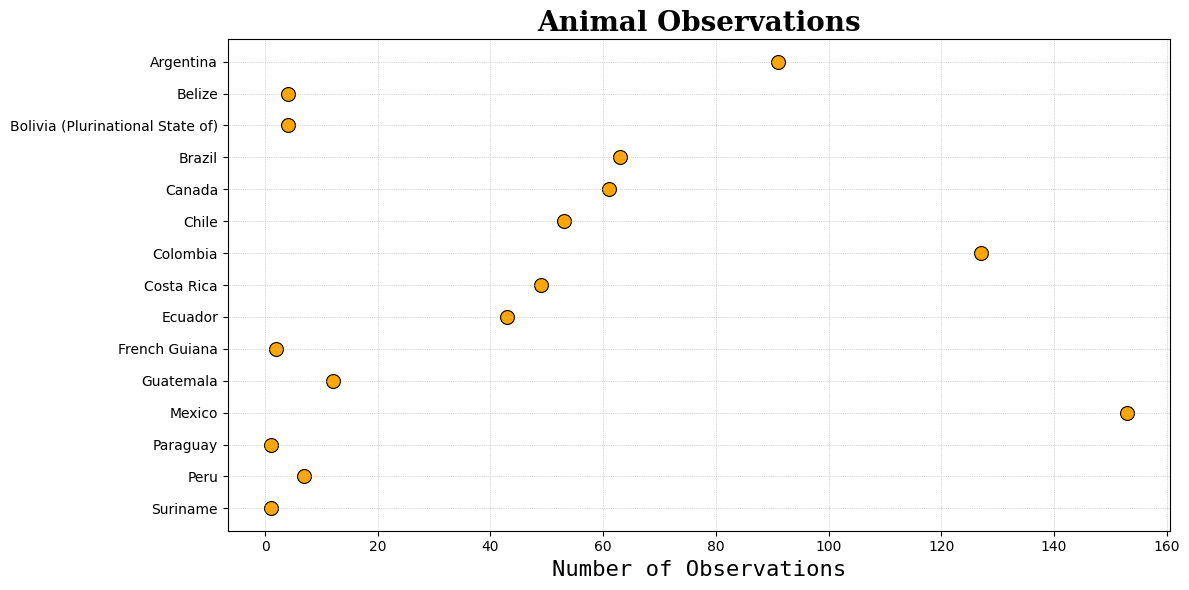

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_yearly_observations_trend(df):
    # Group by country and count occurrences
    yearly_obs = df.groupby('country').size()
    
    # Initialize the plot
    plt.figure(figsize=(12, 6))
    
    # Plot each point with different colors and markers, without connecting lines
    sns.scatterplot(x=yearly_obs.values, y=yearly_obs.index, s=100, color="orange", edgecolor="black", marker='o')
    
    # Additional plot styling
    plt.title('Animal Observations', fontsize=20, fontweight='bold', fontfamily='serif')
    plt.xlabel('Number of Observations', fontsize=16, fontfamily = "monospace")
    plt.ylabel('', fontsize=16)
    plt.grid(visible=True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_yearly_observations_trend(df_filtered)

In [6]:
# Step 5: Fetch iNaturalist and GBIF data for distribution and sightings
def get_inaturalist_data(species_name):
    url = f"https://api.inaturalist.org/v1/observations?taxon_name={species_name}&per_page=50"
    response = requests.get(url)
    data = response.json()
    return data.get("results", [])

def get_gbif_data(species_name):
    gbif_search_url = f"https://api.gbif.org/v1/species?name={species_name}"
    search_response = requests.get(gbif_search_url)
    search_data = search_response.json()
    
    if search_data["results"]:
        species_key = search_data["results"][0]["key"]
        occurrences_url = f"https://api.gbif.org/v1/occurrence/search?taxonKey={species_key}&limit=50"
        occurrences_response = requests.get(occurrences_url)
        return occurrences_response.json().get("results", [])
    return []

# Step 6: Create visualizations for distribution
def plot_sightings_map(iNaturalist_data, gbif_data):
    m = folium.Map(location=[0, 0], zoom_start=2)
    
    # Plot iNaturalist data
    for obs in iNaturalist_data:
        if obs.get("geojson") and obs["geojson"].get("coordinates"):
            coords = obs["geojson"]["coordinates"]
            folium.Marker(
                location=[coords[1], coords[0]],
                popup=obs.get("species_guess", "Unknown Species"),
                icon=folium.Icon(color="green")
            ).add_to(m)
    
    # Plot GBIF data
    for obs in gbif_data:
        if "decimalLatitude" in obs and "decimalLongitude" in obs:
            folium.CircleMarker(
                location=[obs["decimalLatitude"], obs["decimalLongitude"]],
                radius=3,
                color="blue",
                fill=True,
                fill_opacity=0.6
            ).add_to(m)

    return m  # Return the map object

# Fetch data
species_name = "panthera leo"  # Replace with the species name you are analyzing
iNaturalist_data = get_inaturalist_data(species_name)
gbif_data = get_gbif_data(species_name)

# Plot and display the map
sightings_map = plot_sightings_map(iNaturalist_data, gbif_data)
sightings_map  # In a Jupyter notebook, this will display the map directly

NameError: name 'requests' is not defined